In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [154]:
# Store csv file in a Pandas DataFrame
df = pd.read_csv('combined_labled_k6.csv')
df.head()

,samples,joint_effort[0],joint_effort[1],joint_effort[2],joint_effort[3],joint_effort[4],joint_effort[5],cluster
0,0,1.050352,0.036084,0.153670,-0.208722,-0.226335,0.071900,0
1,1,1.040706,0.052485,0.160204,-0.204533,-0.222889,0.070273,0
2,2,1.070528,0.033901,0.198342,-0.208156,-0.228432,0.070408,0
3,3,1.078726,0.032952,0.203791,-0.208763,-0.228608,0.071877,0
4,4,1.046257,0.048101,0.215115,-0.205263,-0.223011,0.071184,0


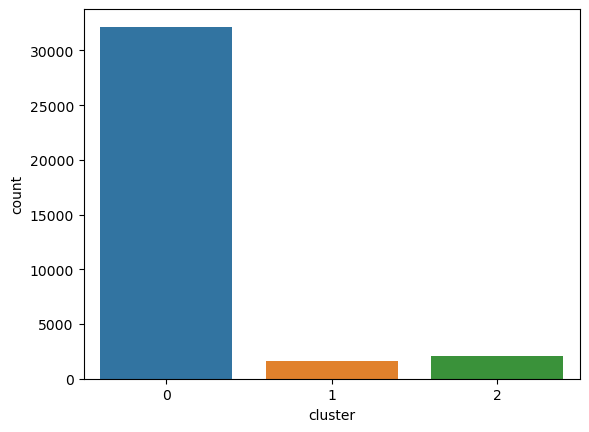

In [155]:
sns.countplot(x = 'cluster', data=df)

In [156]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
X=np.array(X)
y= np.array(y)

In [157]:
X

array([[ 1.05035197,  0.03608361,  0.15366994, -0.20872176, -0.22633529,
         0.07190013],
       [ 1.04070593,  0.05248472,  0.16020391, -0.20453307, -0.22288895,
         0.07027318],
       [ 1.07052848,  0.03390063,  0.19834174, -0.20815593, -0.22843161,
         0.07040757],
       ...,
       [ 2.18775072,  0.72399379, -0.04694298, -0.1240152 , -0.3555519 ,
        -0.3742596 ],
       [ 2.17323085,  0.76483473, -0.16630029, -0.11638658, -0.3595942 ,
        -0.37862044],
       [ 2.21371423,  0.70888995, -0.01968097, -0.12413878, -0.36091259,
        -0.37732746]])

In [158]:
y=y.reshape(-1,1)
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [160]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28670, 6)
(7168, 6)
(28670, 1)
(7168, 1)


In [161]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [162]:
## train dataclass TrainData(Dataset):
#from http.client import _DataType


class TrainData(Dataset):   
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        self.window=5
        
    def __getitem__(self, index):
        if index>= self.length-self.window:
            X=self.X_data[index:index+self.window,]
            Y=self.y_data[index,]
        else:
            X=self.X_data[index:index+self.window,]  
            Y=self.y_data[index+self.window,]
        
        return X,Y
        
    def __len__ (self):
        Q = len(self.X_data)
        self.length=Q-self.window+1
        return self.length


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

## test data  
# class TestData(Dataset):
    
#     def __init__(self, X_data,y_data):
#         self.X_data = X_data
#         self.y_data = y_data
#         self.window=5
#     def __getitem__(self, index):
#         if index>= self.length-self.window:
#             X=self.X_data[index:index+self.window]
#             Y=self.y_data[index,]

#         else:
#             X=self.X_data[index:index+self.window]  
#             Y=self.y_data[index+self.window,]
        
#         return X,Y
#     def __len__ (self):
#         Q = len(self.X_data)
#         self.length=Q-self.window+1
#         return self.length
    

test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))                      

In [163]:



batch_size=25

train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=batch_size, drop_last=True)


val_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=batch_size, drop_last=True)
print(next(iter(train_loader))[0].shape[0])
#print(train_loader.batch_size)
for each_x, each_y in train_loader:
    print(each_x.shape)
    print(each_y.shape)
    break
    
    

for each_x,each_y in val_loader:
    print(each_x.shape)
    print(each_y.shape)
    break

25
torch.Size([25, 5, 6])
torch.Size([25, 1])
torch.Size([25, 5, 6])
torch.Size([25, 1])


In [164]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [165]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        #print(x,h)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [170]:

def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    print(next(iter(train_loader))[0].shape[2])
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device), h)
            loss = criterion(out, label.to(device))
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [167]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.time()
    j=0
    for i in test_x:
        inp = torch.from_numpy(np.array(test_x[j]))
        labs = torch.from_numpy(np.array(test_y[j]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        j+=1
    print("Evaluation Time: {}".format(str(time.time()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [171]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
#Lstm_model = train(train_loader, lr, model_type="LSTM")

6
Starting Training of GRU model
Epoch 1......Step: 200/1146....... Average Loss for Epoch: 0.24341930935624986
Epoch 1......Step: 400/1146....... Average Loss for Epoch: 0.24998593902448193
Epoch 1......Step: 600/1146....... Average Loss for Epoch: 0.2494448852802937
Epoch 1......Step: 800/1146....... Average Loss for Epoch: 0.2492673510790337
Epoch 1......Step: 1000/1146....... Average Loss for Epoch: 0.2504814660632983
Epoch 1/5 Done, Total Loss: 0.2516305697699895
Total Time Elapsed: 3499.488090991974 seconds
Epoch 2......Step: 200/1146....... Average Loss for Epoch: 0.260341687630862
Epoch 2......Step: 400/1146....... Average Loss for Epoch: 0.25887798846699295
Epoch 2......Step: 600/1146....... Average Loss for Epoch: 0.24901381958431254
Epoch 2......Step: 800/1146....... Average Loss for Epoch: 0.24878525632550008
Epoch 2......Step: 1000/1146....... Average Loss for Epoch: 0.2507775096585974
Epoch 2/5 Done, Total Loss: 0.2507995098892658
Total Time Elapsed: 3.9013826847076416 se

In [169]:
#gru_outputs, targets, gru_sMAPE = evaluate(gru_model, X_test, y_test, y_test)